In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

from qiskit import *

import matplotlib.pyplot as plt

In [4]:
freq_0 = 4.9e9
amp_0 = 0.05952946266816971
beta_0 = -0.050505050505050386

freq_1 = 5.5e9
amp_1 = 0.050331228595673023
beta_1 = -0.22448979591836737

In [5]:
import numpy as np
from qiskit import pulse
from qiskit_dynamics import Solver, DynamicsBackend 
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate, HGate
from qiskit.circuit import Parameter, Gate
from qiskit.providers.backend import QubitProperties
from qiskit.transpiler import InstructionProperties
from qiskit.providers.models import PulseDefaults


class TwoQubitPulseSimulator():
    def __init__(
        self,
        qubit_frequency_0 = 4.9e9,
        qubit_frequency_1 = 5.5e9,
        anharmonicity_0 = -0.4e9,
        anharmonicity_1 = -0.3e9,
        drive_strength_0 = 0.22e9,
        drive_strength_1 = 0.26e9,
    ):
        dim = 2

        self.v0 = qubit_frequency_0
        self.anharmon_0 = anharmonicity_0
        self.r0 = drive_strength_0
        
        self.v1 = qubit_frequency_1
        self.anharmon_1 = anharmonicity_1
        self.r1 = drive_strength_1
        
        self.J = 2.7e6
        
        a = np.diag(np.sqrt(np.arange(1, dim)), 1)
        adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
        N = np.diag(np.arange(dim))
        
        ident = np.eye(dim, dtype=complex)
        full_ident = np.eye(dim**2, dtype=complex)
        
        N0 = np.kron(ident, N)
        N1 = np.kron(N, ident)
        
        a0 = np.kron(ident, a)
        a1 = np.kron(a, ident)
        
        a0dag = np.kron(ident, adag)
        a1dag = np.kron(adag, ident)
        
        
        static_ham0 = 2 * np.pi * self.v0 * N0 + np.pi * self.anharmon_0 * N0 * (N0 - full_ident)
        static_ham1 = 2 * np.pi * self.v1 * N1 + np.pi * self.anharmon_1 * N1 * (N1 - full_ident)
        
        static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * self.J * ((a0 + a0dag) @ (a1 + a1dag))
        
        drive_op0 = 2 * np.pi * self.r0 * (a0 + a0dag)
        drive_op1 = 2 * np.pi * self.r1 * (a1 + a1dag)

        # build solver
        dt = 1/4.5e9
        
        self.solver = Solver(
            static_hamiltonian=static_ham_full,
            hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
            # rotating_frame=static_ham_full,
            hamiltonian_channels=["d0", "d1", "u0", "u1"],
            channel_carrier_freqs={"d0": self.v0, "d1": self.v1, "u0": self.v1, "u1": self.v0},
            dt=dt,
            array_library="jax",
        )

        # Consistent solver option to use throughout notebook
        solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
        
        self.backend = DynamicsBackend(
            solver=self.solver,
            subsystem_dims=[dim, dim], # for computing measurement data
            solver_options=solver_options, # to be used every time run is called
            max_outcome_level=dim,
        )

        # self.backend.set_options(
        #     defaults = PulseDefaults.from_dict(
        #         {
        #             "qubit_freq_est": [self.v0, self.v1],
        #             "meas_freq_est": [0, 0],
        #             "buffer": 0,
        #             "pulse_library": [],
        #             "cmd_def":[]
        #         }
        #     )
        # )

        self.target = self.backend.target

        # qubit properties
        self.target.qubit_properties = [QubitProperties(frequency=self.v0), QubitProperties(frequency=self.v1)]
        
        #####################################################################################
        ##### add instructions for qutrits #####

        x01_gate = Gate('x01', 1, [])
        
        with pulse.build() as x01_0:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(0))
        
        with pulse.build() as x01_1:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(1))

        self.target.add_instruction(
            x01_gate,
            {
                (0,): InstructionProperties(calibration=x01_0), 
                (1,): InstructionProperties(calibration=x01_1)
            }
        )
        
        # self.target.add_instruction(XGate(), properties={(0,): None, (1,): None})
        # self.target.add_instruction(SXGate(), properties={(0,): None, (1,): None})
        
        self.target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})
        
        #### Add RZ instruction as phase shift for drag cal  #####
        phi = Parameter("phi")
        with pulse.build() as rz0:
            pulse.shift_phase(phi, pulse.DriveChannel(0))
            pulse.shift_phase(phi, pulse.ControlChannel(1))
        
        with pulse.build() as rz1:
            pulse.shift_phase(phi, pulse.DriveChannel(1))
            pulse.shift_phase(phi, pulse.ControlChannel(0))
        
        self.target.add_instruction(
            RZGate(phi),
            {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
        )

        ##################################################################################

        self.backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

    def get_backend(self):
        return self.backend

    def get_solver(self):
        return self.solver

    def get_target(self):
        return self.target

In [6]:
sim = TwoQubitPulseSimulator()
target = sim.get_target()
backend = sim.get_backend()

In [7]:
dchan0 = pulse.DriveChannel(0)
dchan1 = pulse.DriveChannel(1)

uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

achan0 = pulse.AcquireChannel(0)
achan1 = pulse.AcquireChannel(1)

memslot = pulse.MemorySlot(0)

### Checking how to initial state evolves over time for different control and target states when cr_freq = freq_1

In [8]:
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import *
from qiskit.quantum_info import *
import scipy.linalg as la

In [9]:
dt = 1/4.5e9

In [8]:
min_amp = 0
max_amp = 1
steps = 100

def get_cr_pulse(init_state, cr_drive_freq, cr_amp):
    ctrl, target = init_state
    tot_time = 1000 + 640
    with pulse.build(name="cr_0") as cr_pulse:
        if ctrl == '1':
            pulse.set_frequency(freq_0, dchan0)
            pulse.play(pulse.Drag(320, amp_0, 80, beta_0, limit_amplitude=False), dchan0)
        
        if target == '1':
            pulse.set_frequency(freq_1, dchan1)
            pulse.play(pulse.Drag(320, amp_1, 80, beta_1, limit_amplitude=False), dchan1)
        
        if ctrl == '1' or target == '1':
            delay_time = 320
        else:
            delay_time = 0
        
        pulse.delay(delay_time, uchan0)
        pulse.set_frequency(cr_drive_freq, uchan0)
        pulse.play(pulse.GaussianSquare(1000, cr_amp, 64, 800, limit_amplitude=False), uchan0)
        
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

pop_characterization_jobs = [[] for i in range(4)]
basis_states = ['00', '01', '10', '11']

for i, state in enumerate(basis_states):
    print(i)
    for cr_amp in np.linspace(min_amp, max_amp, steps):
        cr_pulse = get_cr_pulse(state, freq_1, cr_amp)
        cr_job = backend.run(cr_pulse)
        pop_characterization_jobs[i].append(cr_job)

0
1
2
3


In [10]:
pop_vals = [[] for state in basis_states]

for i, state in enumerate(basis_states):
    for job in pop_characterization_jobs[i]:
        pop_vals[i].append(job.result().get_counts())

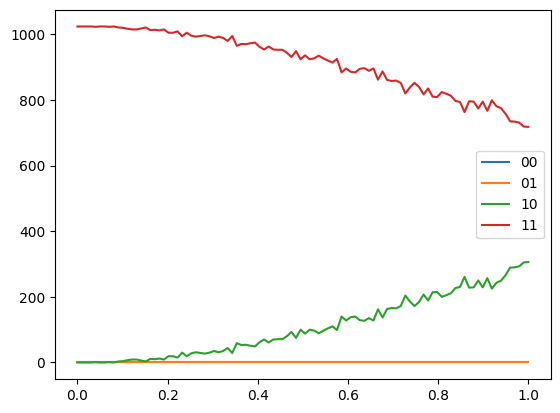

In [17]:
vals = [[] for state in basis_states]

for count in pop_vals[3]:
    for state in basis_states:
        if state in count:
            vals[int(state,2)].append(count[state])
        else:
            vals[int(state,2)].append(0.)

amp_list = np.linspace(min_amp, max_amp, steps)
for i in range(4):
    plt.plot(amp_list, vals[i])
plt.legend(basis_states)

In [17]:
min_duration = 100
max_duration = 2000
step_size = 50


def get_cr_pulse(init_state, cr_drive_freq):
    ctrl, target = init_state
    dur = Parameter('duration')
    with pulse.build(name="cr_0") as cr_pulse:
        if ctrl == '1':
            pulse.set_frequency(freq_0, dchan0)
            pulse.play(pulse.Drag(320, amp_0, 80, beta_0, limit_amplitude=False), dchan0)
        
        if target == '1':
            pulse.set_frequency(freq_1, dchan1)
            pulse.play(pulse.Drag(320, amp_1, 80, beta_1, limit_amplitude=False), dchan1)
        
        if ctrl == '1' or target == '1':
            delay_time = 320
        else:
            delay_time = 0
        
        pulse.delay(delay_time, uchan0)
        pulse.set_frequency(cr_drive_freq, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 0.18, 64, 0.8*dur, limit_amplitude=False), uchan0)
        
        pulse.delay(delay_time + dur, achan0)
        pulse.delay(delay_time + dur, achan1)
        
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

pop_characterization_jobs = [[] for i in range(4)]
basis_states = ['00','01','10','11']

# for i, state in enumerate(basis_states):
state = '10'
for dur in np.arange(min_duration, max_duration, step_size):
    if dur %500 == 0 or dur==100:
        print('state, dur = ', state, dur)
    cr_pulse = get_cr_pulse(state, freq_1)

    cr_pulse.assign_parameters({'duration': int(dur)})

    cr_job = backend.run(cr_pulse, meas_level=2, max_outcome_level=1)
    pop_characterization_jobs[0].append(cr_job)

state, dur =  10 100
state, dur =  10 500
state, dur =  10 1000
state, dur =  10 1500


In [11]:
from qiskit_experiments.curve_analysis.fit_function import *
from scipy.optimize import *

In [18]:
pop_values_11 = [[] for i in range(4)]
basis_states = ['00','01','10','11']

for j, res in enumerate(pop_characterization_jobs[0]):
    print(res.result().get_counts())
    for i in basis_states:
        if i in res.result().get_counts():
            pop_values_11[int(i, 2)].append(res.result().get_counts()[i]/1024)
        else:
            pop_values_11[int(i, 2)].append(0)

{np.str_('10'): np.int64(1024)}
{np.str_('10'): np.int64(1024)}
{np.str_('10'): np.int64(1023), np.str_('11'): np.int64(1)}
{np.str_('10'): np.int64(1024)}
{np.str_('10'): np.int64(1021), np.str_('11'): np.int64(3)}
{np.str_('10'): np.int64(1022), np.str_('11'): np.int64(2)}
{np.str_('10'): np.int64(1023), np.str_('11'): np.int64(1)}
{np.str_('10'): np.int64(1022), np.str_('11'): np.int64(2)}
{np.str_('10'): np.int64(1019), np.str_('11'): np.int64(5)}
{np.str_('10'): np.int64(1023), np.str_('11'): np.int64(1)}
{np.str_('10'): np.int64(1020), np.str_('11'): np.int64(4)}
{np.str_('10'): np.int64(1018), np.str_('11'): np.int64(6)}
{np.str_('10'): np.int64(1015), np.str_('11'): np.int64(9)}
{np.str_('10'): np.int64(1018), np.str_('11'): np.int64(6)}
{np.str_('10'): np.int64(1018), np.str_('11'): np.int64(6)}
{np.str_('10'): np.int64(1018), np.str_('11'): np.int64(6)}
{np.str_('10'): np.int64(1015), np.str_('11'): np.int64(9)}
{np.str_('10'): np.int64(1014), np.str_('11'): np.int64(10)}
{np

In [19]:
dur_list = np.arange(min_duration, max_duration, step_size)
opt_params, _ = curve_fit(cos, dur_list, pop_values_11[3], bounds=([-2, 0, -2*np.pi, 0], [2, 0.001, np.pi, 1]))

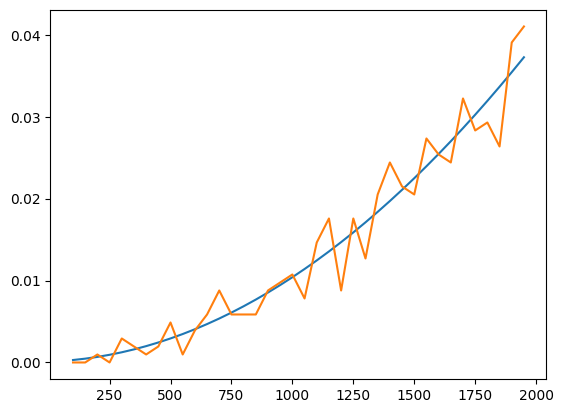

In [20]:
min_duration = 100
max_duration = 2000
step_size = 50

dur_list = np.arange(min_duration, max_duration, step_size)

plt.plot(dur_list, cos(dur_list, *opt_params))
# for i in range(4):
plt.plot(dur_list, pop_values_11[3])
# plt.legend(basis_states)

In [92]:
opt_params

array([5.14851333e-01, 2.91151453e-04, 1.25492075e-01, 5.08971462e-01])

In [16]:
amp = 1/(2*opt_params[1])
print(amp)

22752.873431339067


In [21]:
amp = 1/(2*opt_params[1])
print(amp)

21567.914967754234


In [15]:
pop_values = [[[] for i in range(4)] for i in range(4)]
basis_states = ['00','01','10','11']

for j, item in enumerate(pop_characterization_jobs):
    for res in item:
        for i in basis_states:
            if i in res.result().get_counts():
                pop_values[j][int(i, 2)].append(res.result().get_counts()[i]/1024)
            else:
                pop_values[j][int(i, 2)].append(0)

In [49]:
import pickle

with open("pop_values_freq_1.pkl", "wb") as f:
    pickle.dump(pop_values, f)

In [2]:
import pickle

with open('pop_values_freq_1.pkl','rb') as f: 
    pickled_pop_values = pickle.load(f)

In [47]:
dur_list[18]

np.int64(1000)

In [48]:
dur_list[np.where(pickled_pop_values[0][0] == min(pickled_pop_values[0][0]))]

array([1100])

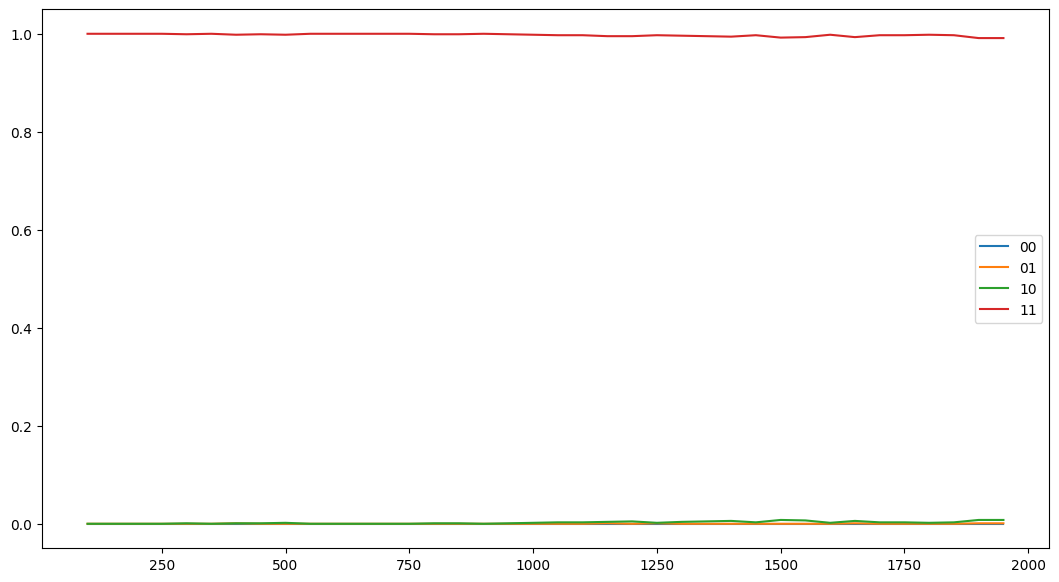

In [37]:
min_duration = 100
max_duration = 2000
step_size = 50

dur_list = np.arange(min_duration, max_duration, step_size)
basis_states = ['00','01','10','11']

plt.figure(figsize=(13,7))
for i in range(4):
    plt.plot(dur_list, pop_values[3][i])
plt.legend(basis_states)

### Checking how to initial state evolves over time for different control and target states when cr_freq = ef_freq_1

In [16]:
min_duration = 100
max_duration = 2000
step_size = 50

theta_1 = 2*np.acos(np.sqrt(1/3))
theta_2 = 2*np.acos(np.sqrt(1/2))

def get_cr_pulse(init_state, cr_drive_freq):
    ctrl, target = init_state
    dur = Parameter('duration')
    with pulse.build(name="cr_0") as cr_pulse:
        if ctrl == '1':
            pulse.set_frequency(freq_0, dchan0)
            pulse.play(pulse.Drag(320, amp_0, 80, beta_0, limit_amplitude=False), dchan0)
        
        if target == '1':
            pulse.set_frequency(freq_1, dchan1)
            pulse.play(pulse.Drag(320, amp_1, 80, beta_1, limit_amplitude=False), dchan1)
        
        if ctrl == '1' or target == '1':
            delay_time = 320
        else:
            delay_time = 0
        
        pulse.set_frequency(cr_drive_freq, uchan0)
        pulse.delay(delay_time, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 2, 64, 0.8*dur, limit_amplitude=False), uchan0)
        
        pulse.delay(delay_time + dur, achan0)
        pulse.delay(delay_time + dur, achan1)
        
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

pop_characterization_jobs = [[] for i in range(4)]
basis_states = ['00','01','10','11']

for i, state in enumerate(basis_states):
    for dur in np.arange(min_duration, max_duration, step_size):
        if dur %500 == 0 or dur==100:
            print('state, dur = ', state, dur)
        cr_pulse = get_cr_pulse(state, freq_1)

        cr_pulse.assign_parameters({'duration': int(dur)})

        cr_job = backend.run(cr_pulse)
        pop_characterization_jobs[i].append(cr_job)

state, dur =  00 100
state, dur =  00 500
state, dur =  00 1000
state, dur =  00 1500
state, dur =  01 100
state, dur =  01 500
state, dur =  01 1000
state, dur =  01 1500
state, dur =  10 100
state, dur =  10 500
state, dur =  10 1000
state, dur =  10 1500
state, dur =  11 100
state, dur =  11 500
state, dur =  11 1000
state, dur =  11 1500


In [17]:
pop_values = [[[] for i in range(4)] for i in range(4)]
basis_states = ['00','01','10','11']

for j, item in enumerate(pop_characterization_jobs):
    for res in item:
        for i in basis_states:
            if i in res.result().get_counts():
                pop_values[j][int(i, 2)].append(res.result().get_counts()[i]/1024)
            else:
                pop_values[j][int(i, 2)].append(0)

In [18]:
import pickle

with open("qubit_pop_values_freq_1.pkl", "wb") as f:
    pickle.dump(pop_values, f)

In [19]:
with open('qubit_pop_values_freq_1.pkl','rb') as f: 
    pickled_pop_values = pickle.load(f)

In [24]:
dur_list[np.where(pickled_pop_values[1][1] == np.array([min(pickled_pop_values[1][1])]))]

array([1650])

In [25]:
dur_list[np.where(pickled_pop_values[3][3] == np.array([min(pickled_pop_values[3][3])]))]

array([1650])

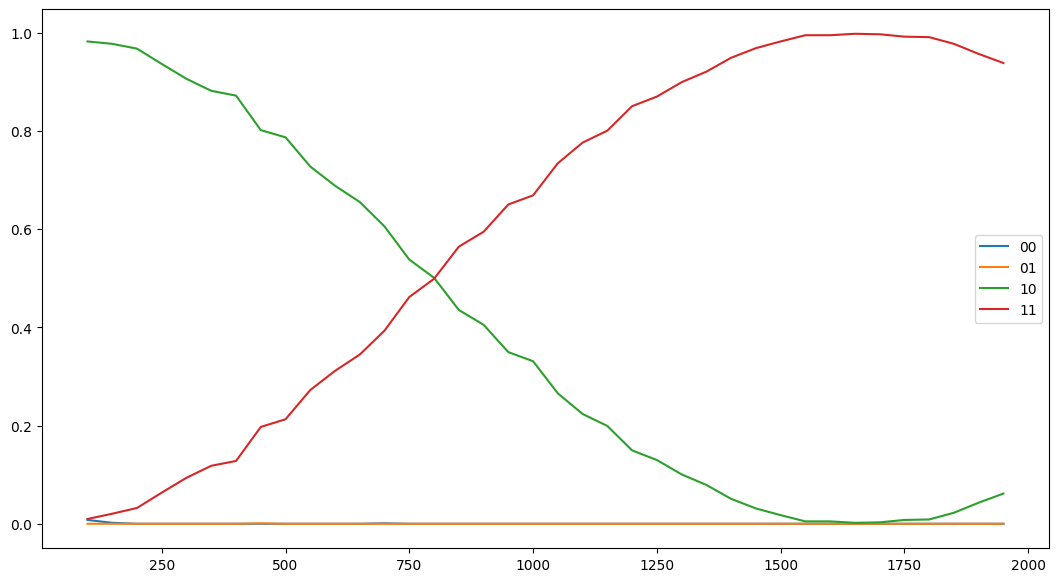

In [39]:
min_duration = 100
max_duration = 2000
step_size = 50
dur_list = np.arange(min_duration, max_duration, step_size)
basis_states = ['00','01','10','11']

plt.figure(figsize=(13,7))
for i in range(4):
    plt.plot(dur_list, pickled_pop_values[2][i])
plt.legend(basis_states)

### Checking the effects of duration in the cross resonance when the CR frequency is set as freq_1

### Setting control qubit in the state $|0\rangle$

In [28]:
min_duration = 500
max_duration = 4000
steps = 100

theta_1 = 2*np.acos(np.sqrt(1/2))

def get_cr_pulse():
    dur = Parameter('duration')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_1, dchan1)
        pulse.play(pulse.Drag(320, (theta_1/np.pi)*amp_1, 80, beta_1), dchan1)
        
        pulse.set_frequency(freq_1, uchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 2, 64, 0.8*dur, limit_amplitude=False), uchan0)
        
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array_0_dur = []
for i, dur in enumerate(np.linspace(min_duration, max_duration, steps)):
    if i%20 == 0:
        print('dur : ', dur)
    cr_pulse = get_cr_pulse()
    
    cr_pulse.assign_parameters({'duration': int(dur)})
    cr_job = backend.run(cr_pulse)
    cr_job_array_0_dur.append(cr_job)

dur :  500.0
dur :  1207.0707070707072
dur :  1914.1414141414143
dur :  2621.2121212121215
dur :  3328.2828282828286


In [29]:
cr_0_prob_dur = [[],[]]

counts = 0
tot_counts = 0
for res in cr_job_array_0_dur:
    for i in range(2):
        if '0'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['0'+str(i)]
        else:
            counts = 0
        cr_0_prob_dur[i].append(counts)
    tot_counts = cr_0_prob_dur[0][-1] + cr_0_prob_dur[1][-1]
    for i in range(2):
        cr_0_prob_dur[i][-1] = cr_0_prob_dur[i][-1]/tot_counts
#         cr_0_prob_dur[i][-1] = cr_0_prob_dur[i][-1]/1024


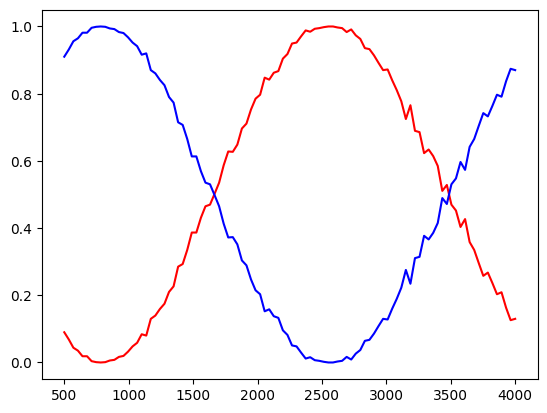

In [30]:
dur_list = np.linspace(min_duration, max_duration, steps)
plt.plot(dur_list, cr_0_prob_dur[0], color='r')
plt.plot(dur_list, cr_0_prob_dur[1], color='b')

### Setting control qubit in the state $|1\rangle$

In [34]:
min_duration = 500
max_duration = 4000
steps = 50

theta_1 = 2*np.acos(np.sqrt(1/2))


def get_cr_pulse():
    dur = Parameter('duration')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Drag(320, amp_0, 80, beta_0, limit_amplitude=False), dchan0)
        
        pulse.set_frequency(freq_1, dchan1)
        pulse.play(pulse.Drag(320, (theta_1/np.pi)*amp_1, 80, beta_1, limit_amplitude=False), dchan1)
        
        pulse.set_frequency(freq_1, uchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 2, 64, 0.8*dur, limit_amplitude=False), uchan0)
        
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array_1_dur = []
for i, dur in enumerate(np.linspace(min_duration, max_duration, steps)):
    if i%20 == 0:
        print('dur : ', dur)
    cr_pulse = get_cr_pulse()
    
    cr_pulse.assign_parameters({'duration': int(dur)})
    cr_job = backend.run(cr_pulse)
    cr_job_array_1_dur.append(cr_job)

dur :  500.0
dur :  1928.5714285714287
dur :  3357.1428571428573


In [35]:
cr_1_prob_dur = [[],[]]

counts = 0
tot_counts = 0
for res in cr_job_array_1_dur:
    for i in range(2):
        if '1'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['1'+str(i)]
        else:
            counts = 0
        cr_1_prob_dur[i].append(counts)
    tot_counts = cr_1_prob_dur[0][-1] + cr_1_prob_dur[1][-1]
    for i in range(2):
        cr_1_prob_dur[i][-1] = cr_1_prob_dur[i][-1]/tot_counts
#         cr_1_prob_dur[i][-1] = cr_1_prob_dur[i][-1]/1024


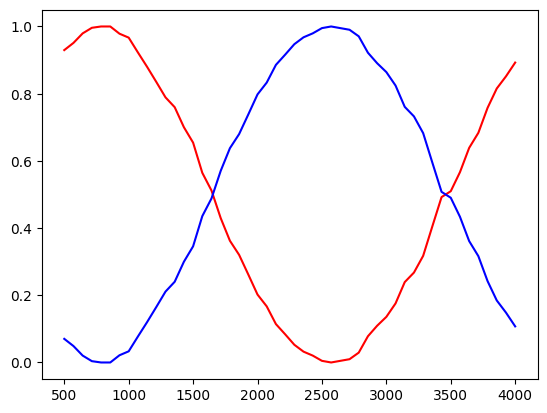

In [36]:
dur_list = np.linspace(min_duration, max_duration, steps)
plt.plot(dur_list, cr_1_prob_dur[0], color='r')
plt.plot(dur_list, cr_1_prob_dur[1], color='b')

### Checking the effects of width in the cross resonance

### Setting the control qubit to the state $|0\rangle$

In [ ]:
min_scale = 0.7
max_scale = 1
steps = 50

def get_cr_pulse():
    dur = int(1500)
    scale = Parameter('scale')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Gaussian(320, 0, 80), dchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 1, 0.05*dur, scale*dur), uchan0)
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array = []
for scale in np.linspace(min_scale, max_scale, steps):
    cr_pulse = get_cr_pulse()

    cr_pulse.assign_parameters({'scale': scale})
    cr_job = backend.run(cr_pulse, meas_level=2, max_outcome_level=2)
    cr_job_array.append(cr_job)

In [ ]:
for res in cr_job_array:
    print(res.result().get_counts())

In [ ]:
cr_0_prob = [[],[],[]]

counts = 0
for res in cr_job_array:
    for i in range(3):
        if '0'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['0'+str(i)]
        else:
            counts = 0
        cr_0_prob[i].append(counts/1024.)

In [ ]:
scale_list = np.linspace(min_scale, max_scale, steps)
plt.plot(scale_list, cr_0_prob[0], color='r')
plt.plot(scale_list, cr_0_prob[1], color='b')
plt.plot(scale_list, cr_0_prob[2], color='g')

### Setting the control qubit to the state $|1\rangle$

In [ ]:
min_scale = 0.9
max_scale = 1
steps = 50

def get_cr_pulse():
    dur = int(1500)
    scale = Parameter('scale')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Gaussian(320, amp_0, 80), dchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 1, 0.05*dur, scale*dur), uchan0)
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array = []
for scale in np.linspace(min_scale, max_scale, steps):
    cr_pulse = get_cr_pulse()

    cr_pulse.assign_parameters({'scale': scale})
    cr_job = backend.run(cr_pulse, meas_level=2, max_outcome_level=2)
    cr_job_array.append(cr_job)

In [ ]:
for res in cr_job_array:
    print(res.result().get_counts())

In [ ]:
cr_1_prob = [[],[],[]]

counts = 0
for res in cr_job_array:
    for i in range(3):
        if '1'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['1'+str(i)]
        else:
            counts = 0
        cr_1_prob[i].append(counts/1024.)

In [ ]:
scale_list = np.linspace(min_scale, max_scale, steps)
plt.plot(scale_list, cr_1_prob[0], color='r')
plt.plot(scale_list, cr_1_prob[1], color='b')
plt.plot(scale_list, cr_1_prob[2], color='g')

## Calculating concurrence as provided in Gambetta's paper

1. First set the state to $(|00\rangle + |10\rangle)/\sqrt{2}$.
2. Apply the CR pulse over varied times and see how the value of the concurrence changes over time

In [9]:
dt = 1/4.5e9

In [10]:
def qubit_concur(state):
    rho = DensityMatrix(state).data
    yy_mat = np.fliplr(np.diag([-1, 1, 1, -1]))
    sigma = rho.dot(yy_mat).dot(rho.conj()).dot(yy_mat)
    w = np.sort(np.real(la.eigvals(sigma)))
    w = np.sqrt(np.maximum(w, 0.0))
    
    return max(0.0, w[-1] - np.sum(w[0:-1]))

In [13]:
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import *
import scipy.linalg as la

def get_bell_pulse(theta_1, freq, amp):
    dur = Parameter('dur')
    with pulse.build(name="cr_0") as super_pulse:
        pulse.set_frequency(freq_0, dchan0)
        
        # Applying a pulse to excite the state of the first qutrit to (|0> + |1>)/sqrt(2)
        pulse.play(pulse.Drag(320, (theta_1/np.pi)*amp_0, 80, beta_0), dchan0)
        
        pulse.set_frequency(freq, uchan0)

#         # Delaying the signal in the control channel by 640 units
        pulse.delay(320, uchan0)
        
#         # Applying the cross resonance pulse on the control channel of first qubit
        pulse.play(pulse.GaussianSquare(dur, amp, 64, 0.8*dur, limit_amplitude=False), uchan0)
        
    return super_pulse

min_dur = 100
max_dur = 4000
steps = 50

concur_array = [[],[],[],[]]
amp_list = [1, 1.5, 2, 2.5]
# amp_list = [2.5]

for i, amp in enumerate(amp_list):
    for dur in np.linspace(min_dur, max_dur, steps):
        theta_1 = 2*np.acos(np.sqrt(1/2))
        test_cr_pulse = get_bell_pulse(theta_1, freq_1, amp)
        test_cr_pulse.assign_parameters({'dur': int(dur)})
        y0 = Statevector([1,0,0,0])
        cr_job = backend.solve(test_cr_pulse, [0, (dur+320)*dt], y0)

        t_state = cr_job[0].y[-1]
        concur_array[i].append(qubit_concur(t_state))
    #     print(np.round(t_state.probabilities(), 4))
    #     print('Concurrence : ', qubit_concur(t_state))

/tmp/ipykernel_71967/2232216410.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as super_pulse:
/tmp/ipykernel_71967/2232216410.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_71967/2232216410.py:11: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiski

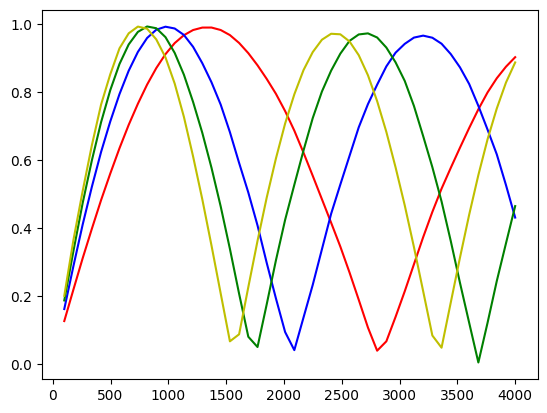

In [14]:
dur_list = np.linspace(min_dur, max_dur, steps)

plt.plot(dur_list, concur_array[0], color='r')
plt.plot(dur_list, concur_array[1], color='b')
plt.plot(dur_list, concur_array[2], color='g')
plt.plot(dur_list, concur_array[3], color='y')